# Run FaIR

Takes emissions in and produces datasets of temperature and aerosol forcing out.

In [1]:
import json
from multiprocessing import Pool
import platform

import fair
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import scipy.stats as st
from tqdm import tqdm
from climateforcing.utils import mkdir_p

## Set up plotting styles

In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 9/2.54)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

## RCMIP SSP1-2.6 emissions

In [3]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750, 2111)
years_future = [2015] + list(range(2020,2111,10))

startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

scenarios = ['ssp119', 'ssp126']

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}

for scenario in scenarios:
    data_out[scenario] = np.ones((361, 40)) * np.nan
    data_out[scenario][:,0] = years

    # past emissions from Zeb
    for i, specie in enumerate(species):
        data_out[scenario][:,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2110'].interpolate(axis=1)*unit_convert[i+1]

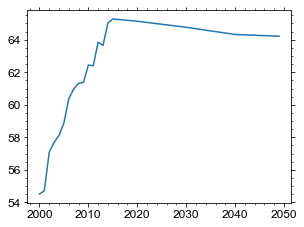

In [4]:
pl.plot(data_out[scenario][250:300, 0], data_out[scenario][250:300, 11])

In [14]:
results_out = {}

## Load up slim configs

This contains about 3700 ensemble members - unlike AR6 we don't use future carbon cycle assessments to constrain the ensemble. Other differences:

- volcanic forcing efficacy of 0.6
- solar forcing zero after 2019

The slim config is a good deal smaller than the AR6 json - but we need a bit of extra code to convert this into what is used in AR6.

In [5]:
with open('../data_input/ar6-fair-samples/fair-1.6.2-wg3-params-common.json') as f:
    config_list_common = json.load(f)

In [6]:
with open('../data_input/ar6-fair-samples/fair-1.6.2-wg3-params-slim-reconstrained.json') as f:
    config_list_variable = json.load(f)

In [7]:
updated_config = []
for i, cfg in enumerate(config_list_variable):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['ssp126']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["efficacy"][43] = 0.6
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    
    e_pi = np.zeros(40)
    c_pi = np.zeros(31)
    scale = np.ones(45)
    for idx in range(5, 12):
        e_pi[idx] = config_list_common["E_pi"][idx - 5]
    c_pi[0] = cfg["C_pi_CO2"]
    c_pi[1] = config_list_common["C_pi"][0]
    c_pi[2] = config_list_common["C_pi"][1]
    c_pi[3] = config_list_common["C_pi"][2]
    c_pi[20] = config_list_common["C_pi"][3]
    c_pi[25] = config_list_common["C_pi"][4]
    c_pi[29] = config_list_common["C_pi"][5]
    c_pi[30] = config_list_common["C_pi"][6]
    scale[1] = cfg["scale"][0]
    scale[2] = cfg["scale"][1]
    for idx in range(3, 31):
        scale[idx] = cfg["scale"][2]
    scale[15] = scale[15] * config_list_common["cfc11_adj"]
    scale[16] = scale[16] * config_list_common["cfc12_adj"]
    scale[33] = cfg["scale"][3]
    scale[34] = cfg["scale"][4]
    scale[41] = cfg["scale"][5]
    scale[42] = cfg["scale"][6]
    scale[43] = cfg["scale"][7]
    f_solar = np.zeros(361)
    f_solar[:270] = (
        np.linspace(0, cfg["trend_solar"], 270)
        + np.array(config_list_common["default_solar"])[:270] * cfg["scale"][8]
    )
    f_solar[270:] = (
        cfg["trend_solar"]
    )
    
    updated_config[i]["b_aero"] = [
        cfg["b_aero"][0],
        0,
        0,
        0,
        cfg["b_aero"][1],
        cfg["b_aero"][2],
        cfg["b_aero"][3],
    ]
    updated_config[i]["E_pi"] = e_pi
    updated_config[i]["scale"] = scale
    updated_config[i]["F_solar"] = f_solar
    updated_config[i]["F_volcanic"] = np.array(config_list_common["default_volcanic"])
    updated_config[i]["C_pi"] = c_pi
    updated_config[i]["ghg_forcing"] = config_list_common["ghg_forcing"]
    updated_config[i]["aCO2land"] = config_list_common["aCO2land"]
    updated_config[i]["stwv_from_ch4"] = config_list_common["stwv_from_ch4"]
    updated_config[i]["F_ref_BC"] = config_list_common["F_ref_BC"]
    updated_config[i]["E_ref_BC"] = config_list_common["E_ref_BC"]
    updated_config[i]["tropO3_forcing"] = config_list_common["tropO3_forcing"]
    updated_config[i]["natural"] = np.array(config_list_common["natural"])
    
    # delete params that are not arguments to fair
    del updated_config[i]["trend_solar"]
    del updated_config[i]["C_pi_CO2"]

In [8]:
updated_config[0]

{'scale': array([1.        , 0.59459242, 0.99450494, 0.82175573, 0.82175573,
        0.82175573, 0.82175573, 0.82175573, 0.82175573, 0.82175573,
        0.82175573, 0.82175573, 0.82175573, 0.82175573, 0.82175573,
        0.92858398, 0.92036642, 0.82175573, 0.82175573, 0.82175573,
        0.82175573, 0.82175573, 0.82175573, 0.82175573, 0.82175573,
        0.82175573, 0.82175573, 0.82175573, 0.82175573, 0.82175573,
        0.82175573, 1.        , 1.        , 1.13426869, 1.10513261,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.66017135, 0.94994879, 0.92693156, 1.        ]),
 'F2x': 3.9450757395459446,
 'r0': 29.041200177431005,
 'rt': 3.4365871714714737,
 'rc': 0.036356462836140684,
 'lambda_global': 1.2279981833970364,
 'ocean_heat_capacity': array([  7.48912096, 125.40488343]),
 'ocean_heat_exchange': 0.7014538799282719,
 'deep_ocean_efficacy': 0.9726477122514848,
 'b_aero': [-0.007423152924638107,
  0,
  0,
  0,
  0.04764131705403072,
  -0.0

## Run FaIR

In [9]:
platform.system()

'Darwin'

In [10]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisT, thisF[:,35:41].sum(axis=1))

def fair_process(emissions):
    updated_config = []
    for i, cfg in enumerate(config_list_variable):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = emissions
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["efficacy"][43] = 0.6
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False

        e_pi = np.zeros(40)
        c_pi = np.zeros(31)
        scale = np.ones(45)
        for idx in range(5, 12):
            e_pi[idx] = config_list_common["E_pi"][idx - 5]
        c_pi[0] = cfg["C_pi_CO2"]
        c_pi[1] = config_list_common["C_pi"][0]
        c_pi[2] = config_list_common["C_pi"][1]
        c_pi[3] = config_list_common["C_pi"][2]
        c_pi[20] = config_list_common["C_pi"][3]
        c_pi[25] = config_list_common["C_pi"][4]
        c_pi[29] = config_list_common["C_pi"][5]
        c_pi[30] = config_list_common["C_pi"][6]
        scale[1] = cfg["scale"][0]
        scale[2] = cfg["scale"][1]
        for idx in range(3, 31):
            scale[idx] = cfg["scale"][2]
        scale[15] = scale[15] * config_list_common["cfc11_adj"]
        scale[16] = scale[16] * config_list_common["cfc12_adj"]
        scale[33] = cfg["scale"][3]
        scale[34] = cfg["scale"][4]
        scale[41] = cfg["scale"][5]
        scale[42] = cfg["scale"][6]
        scale[43] = cfg["scale"][7]
        f_solar = np.zeros(361)
        f_solar[:270] = (
            np.linspace(0, cfg["trend_solar"], 270)
            + np.array(config_list_common["default_solar"])[:270] * cfg["scale"][8]
        )
        f_solar[270:] = (
            cfg["trend_solar"]
    #        + np.array(config_list_common["default_solar"])[270:351] * cfg["scale"][8]
        )
    #    f_solar[351:361] = np.array(config_list_common["default_solar"])[351:]

        updated_config[i]["b_aero"] = [
            cfg["b_aero"][0],
            0,
            0,
            0,
            cfg["b_aero"][1],
            cfg["b_aero"][2],
            cfg["b_aero"][3],
        ]
        updated_config[i]["E_pi"] = e_pi
        updated_config[i]["scale"] = scale
        updated_config[i]["F_solar"] = f_solar
        updated_config[i]["F_volcanic"] = np.array(config_list_common["default_volcanic"])
        updated_config[i]["C_pi"] = c_pi
        updated_config[i]["ghg_forcing"] = config_list_common["ghg_forcing"]
        updated_config[i]["aCO2land"] = config_list_common["aCO2land"]
        updated_config[i]["stwv_from_ch4"] = config_list_common["stwv_from_ch4"]
        updated_config[i]["F_ref_BC"] = config_list_common["F_ref_BC"]
        updated_config[i]["E_ref_BC"] = config_list_common["E_ref_BC"]
        updated_config[i]["tropO3_forcing"] = config_list_common["tropO3_forcing"]
        updated_config[i]["natural"] = np.array(config_list_common["natural"])

        # delete params that are not arguments to fair
        del updated_config[i]["trend_solar"]
        del updated_config[i]["C_pi_CO2"]
        
    # multiprocessing is not working for me on Windows or Mac - so do serial
    if platform.system() in ['Windows', 'Darwin']:
        shape = (361, len(updated_config))
        t = np.ones(shape) * np.nan
        f_aer = np.ones(shape) * np.nan
        for i, cfg in tqdm(enumerate(updated_config), total=len(updated_config), position=0, leave=True):
            t[:,i], f_aer[:,i] = run_fair(updated_config[i])

    else:
        if __name__ == '__main__':
            with Pool(WORKERS) as pool:
                result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config), position=0, leave=True))

        result_t = np.array(result).transpose(1,2,0)
        t, f_aer = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)

    return temp_rebase, f_aer



results_out = {}
WORKERS = 7  # set this based on your individual machine - allows parallelisation. nprocessors-1 is a sensible shout.

for scenario in tqdm(['ssp119', 'ssp126'], position=0, leave=True):
    results_out[scenario] = {}
    (
        results_out[scenario]['temperature'],
        results_out[scenario]['ERFaer']
    ) = fair_process(data_out[scenario])

100%|████████████████████████████████████████████| 2/2 [20:00<00:00, 600.08s/it]


In [11]:
for scenario in scenarios:
    for var in ['temperature', 'ERFaer']:
        mkdir_p('../data_output/fair_{}/'.format(var))
        df_out = pd.DataFrame(results_out[scenario][var][:351,:])
        df_out['year'] = np.arange(1750.5, 2101)
        df_out.set_index('year', inplace=True)
        df_out.to_csv('../data_output/fair_{}/{}.csv'.format(var, scenario), float_format="%6.4f")